# GAN

In [4]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
from tensorflow.keras import models
import time

from IPython import display

In [5]:
import tensorflow as tf

In [9]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [4]:
train_images.shape[0]

60000

In [10]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [11]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [13]:

def make_generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape=(100,)))

    model.add(layers.Dense(7*7*256, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

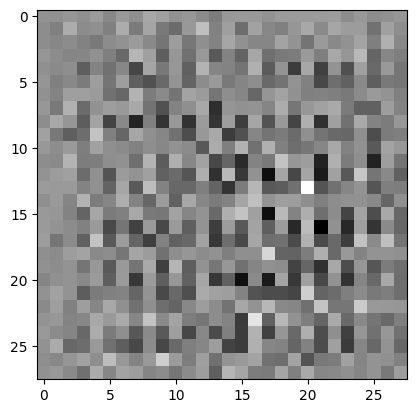

In [14]:
generator = make_generator_model()


noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [15]:


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(28,28,1)))
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))

    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model
     


In [16]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00256049]], shape=(1, 1), dtype=float32)


In [17]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [19]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [15]:


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
     


In [21]:
EPOCHS = 2
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
     


In [23]:


def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  # fig = plt.figure(figsize=(4, 4))

  # for i in range(predictions.shape[0]):
  #     plt.subplot(4, 4, i+1)
  #     plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
  #     plt.axis('off')

  plt.imshow(predictions[0, :, :, 0] * 127.5 + 127.5, cmap='gray')
  # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()
     


In [24]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [20]:
# generator = models.load_model("trained_models.\\generator.keras")
# discriminator = models.load_model("trained_models.\\discriminator.keras")

In [ ]:
train(train_dataset, 1)

In [53]:
generator.save("trained_models.\\generator.keras")
# discriminator.save("trained_models.\\discriminator.keras")

In [23]:
# # Display a single image using the epoch number
# def display_image(epoch_no):
#   return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
     
# display_image(3)

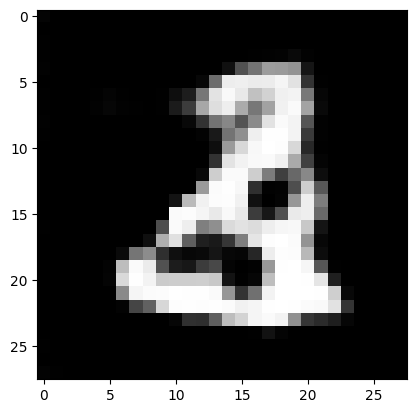

In [6]:
import matplotlib.pyplot as plt
from tensorflow.keras import models
import tensorflow as tf

def generate():
    noise = tf.random.normal([1,100])
    # gen = models.load_model("trained_models.\\generator.keras")
    gen = models.load_model("trained_models.\\generator.keras")
    img  = gen(noise,training=False)
    # img  = generator(noise,training=False)
    
    display.clear_output(wait=True)
    plt.imshow(img[0,:,:,0],cmap='gray')
    time.sleep(1)
    plt.show()

generate()

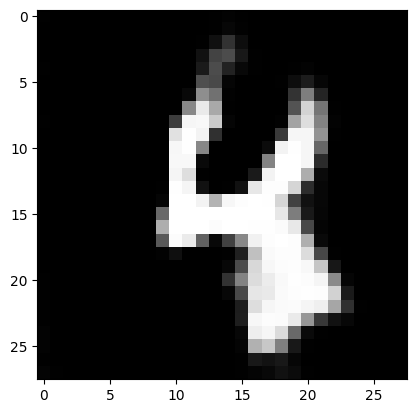

In [7]:
for i in range(10):
    generate()